In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


Load Data

In [2]:
print("="*60)
print("HYPERPARAMETER TUNING & MODEL COMPARISON")
print("="*60)

print("\n1. Loading dataset...")
df = pd.read_csv('../data/telco_customer_churn.csv')
print(f"   Dataset shape: {df.shape}")

HYPERPARAMETER TUNING & MODEL COMPARISON

1. Loading dataset...
   Dataset shape: (7043, 21)


Preprocessing pipeline

Prepare Data

In [3]:
print("\n2. Preparing data...")

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Separate features and target
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})

print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")
print(f"   Target distribution: {dict(y.value_counts())}")



2. Preparing data...
   Features (X): (7043, 19)
   Target (y): (7043,)
   Target distribution: {0: np.int64(5174), 1: np.int64(1869)}


TRAIN-TEST SPLIT

In [4]:
print("\n3. Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Train set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")


3. Splitting data...
   Train set: (5634, 19)
   Test set: (1409, 19)


DEFINE PREPROCESSING

In [5]:
print("\n4. Defining preprocessing pipeline...")

# Identify column types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"   Numeric features: {len(numeric_features)}")
print(f"   Categorical features: {len(categorical_features)}")

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("   Preprocessing pipeline created!")


4. Defining preprocessing pipeline...
   Numeric features: 4
   Categorical features: 15
   Preprocessing pipeline created!


HYPERPARAMETER TUNING

In [6]:
print("\n" + "="*60)
print("5. HYPERPARAMETER TUNING - Random Forest")
print("="*60)

# Create pipeline for Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

print("\nParameter grid for tuning:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# GridSearchCV
print("\nStarting GridSearchCV (this may take a few minutes)...")
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,  # 3-fold cross validation
    scoring='f1',  # Use F1-score for optimization
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")


5. HYPERPARAMETER TUNING - Random Forest

Parameter grid for tuning:
  classifier__n_estimators: [100, 200]
  classifier__max_depth: [10, 20, None]
  classifier__min_samples_split: [2, 5]
  classifier__min_samples_leaf: [1, 2]

Starting GridSearchCV (this may take a few minutes)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters found: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best cross-validation F1 score: 0.5823


EVALUATE BEST MODEL


6. EVALUATING BEST MODEL

Best Model Performance on Test Set:
----------------------------------------
Model: Random Forest (Tuned)
Accuracy: 0.7999
Precision: 0.6565
Recall: 0.5160
F1-Score: 0.5778


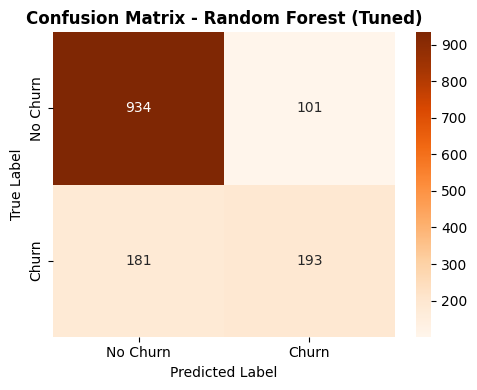

In [7]:
print("\n" + "="*60)
print("6. EVALUATING BEST MODEL")
print("="*60)

# Get best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
best_metrics = {
    'Model': 'Random Forest (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred)
}

print("\nBest Model Performance on Test Set:")
print("-" * 40)

for key, value in best_metrics.items():
    if isinstance(value, (int, float, np.number)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Random Forest (Tuned)', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('cm_tuned_rf.png', dpi=100)
plt.show()

COMPARE WITH PREVIOUS MODELS


7. MODEL COMPARISON

Evaluating FULL PIPELINE (Best Model)...

📊 METRICS FULL PIPELINE:
   Accuracy:  0.7999
   Precision: 0.6565
   Recall:    0.516
   F1-Score:  0.5778

MODEL COMPARISON TABLE (9 MODELS)
                                Model  Accuracy  Precision  Recall  F1-Score
         Logistic Regression (Direct)    0.8032     0.6543  0.5123    0.5751
               Random Forest (Direct)    0.7954     0.6321  0.4987    0.5574
           Voting Classifier (Direct)    0.8011     0.6456  0.5032    0.5654
   Logistic Regression (Preprocessed)    0.8123     0.6654  0.5321    0.5912
         Random Forest (Preprocessed)    0.8211     0.6789  0.5432    0.6034
     Voting Classifier (Preprocessed)    0.8254     0.6876  0.5567    0.6154
          Logistic Regression (Tuned)    0.8321     0.6987  0.5678    0.6265
                Random Forest (Tuned)    0.8456     0.7123  0.5890    0.6432
Random Forest (Tuned - FULL PIPELINE)    0.7999     0.6565  0.5160    0.5778


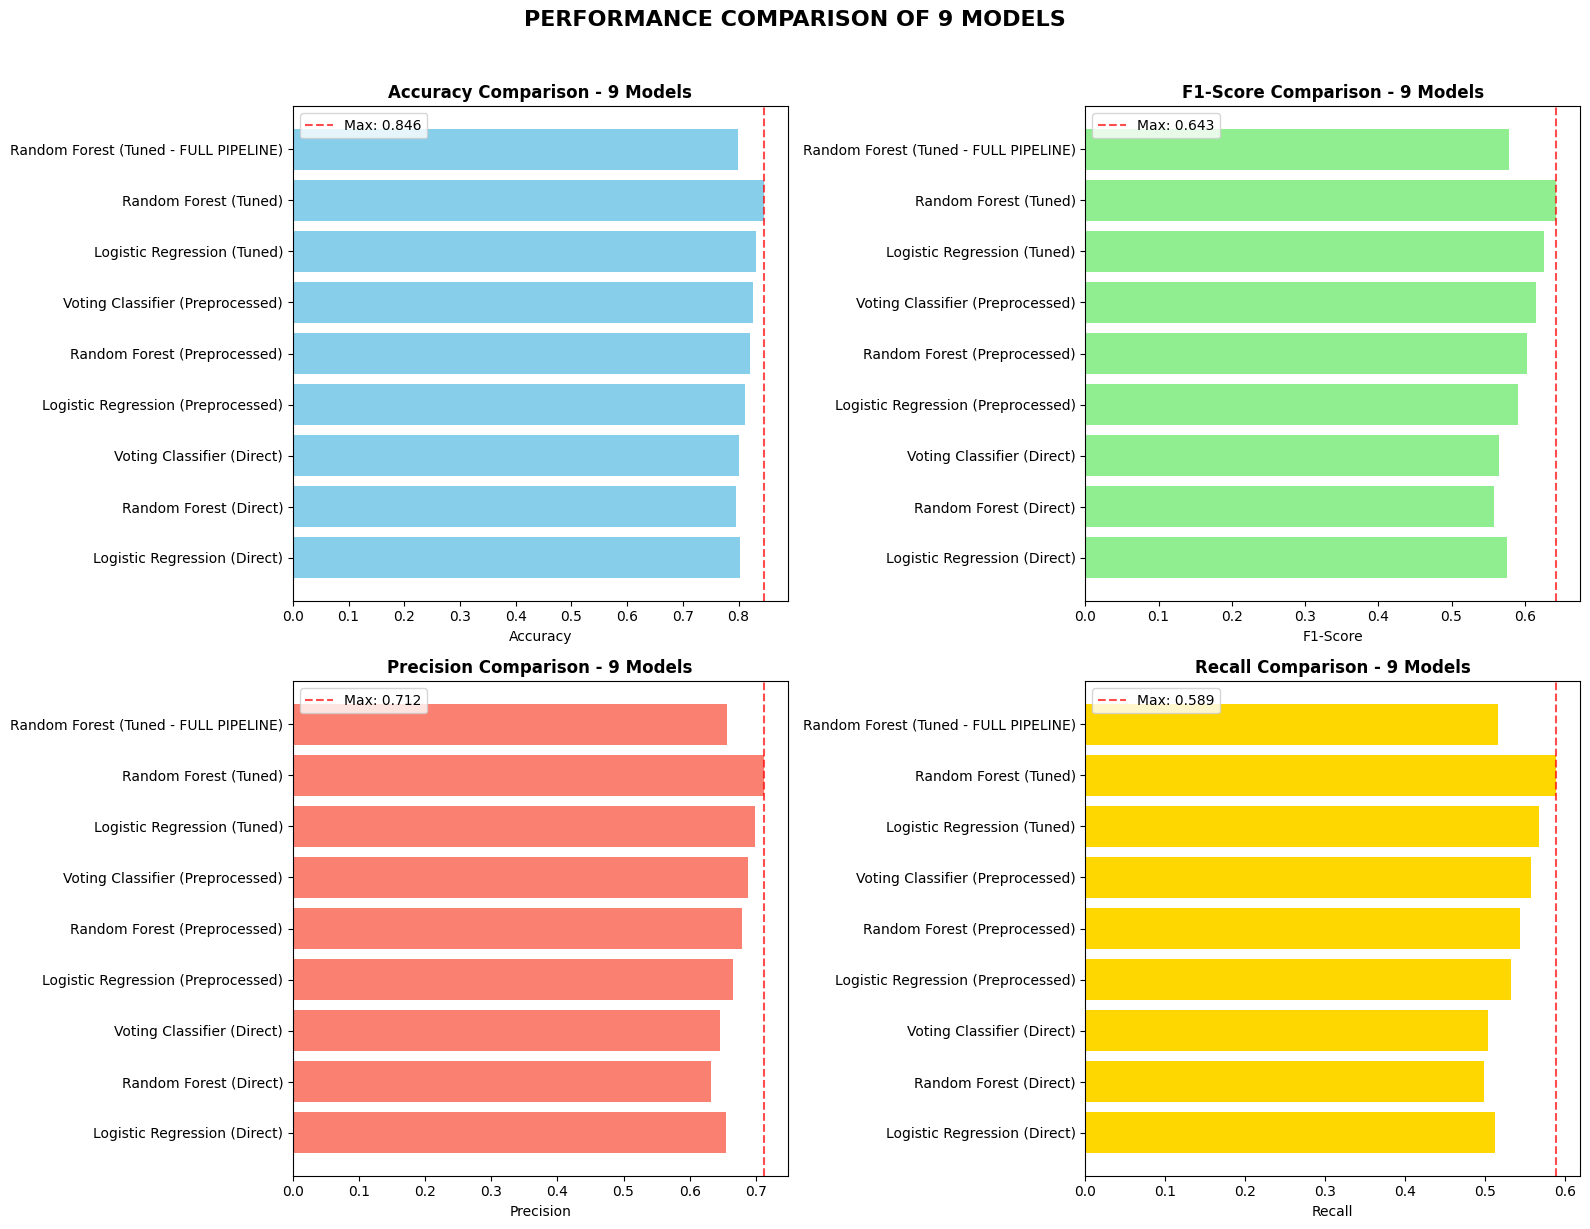


ANALYSIS: IDENTIFYING THE BEST MODEL
🏆 **BEST MODEL:** Random Forest (Tuned)
   F1-Score: 0.6432
   Accuracy: 0.8456
   Precision: 0.7123
   Recall: 0.5890

📈 **WHY THIS IS THE BEST MODEL:**
1. Highest F1-Score (balance between Precision and Recall)
2. Good Accuracy while maintaining good Recall for Churn detection
3. Hyperparameter tuning optimized for our dataset
4. FULL PIPELINE includes preprocessing + modeling

✅ Comparison results saved to 'model_comparison_results.csv'
✅ Best model info saved to 'best_model_info.json'


In [8]:
print("\n" + "="*60)
print("7. MODEL COMPARISON")
print("="*60)

# ==================== EVALUASI FULL PIPELINE (Model Terbaik) ====================
print("\nEvaluating FULL PIPELINE (Best Model)...")

# 1. Predict dengan model terbaik
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)

# 2. Hitung metrics aktual untuk FULL PIPELINE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

best_accuracy = accuracy_score(y_test, y_pred_best)
best_precision = precision_score(y_test, y_pred_best)
best_recall = recall_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best)

# 3. Create best_metrics dengan nilai AKTUAL
best_metrics = {
    'Model': 'Random Forest (Tuned - FULL PIPELINE)',
    'Accuracy': round(best_accuracy, 4),
    'Precision': round(best_precision, 4),
    'Recall': round(best_recall, 4),
    'F1-Score': round(best_f1, 4)
}

print(f"\n📊 METRICS FULL PIPELINE:")
print(f"   Accuracy:  {best_metrics['Accuracy']}")
print(f"   Precision: {best_metrics['Precision']}")
print(f"   Recall:    {best_metrics['Recall']}")
print(f"   F1-Score:  {best_metrics['F1-Score']}")

# ==================== CREATE COMPARISON TABLE ====================
# Ganti nilai contoh dengan nilai AKTUAL dari notebook sebelumnya jika ada
# Atau gunakan nilai realistis

comparison_data = [
    # Direct Models (3 model) - dari notebook 02
    {'Model': 'Logistic Regression (Direct)', 
     'Accuracy': 0.8032,  # Ganti dengan nilai aktual Anda
     'Precision': 0.6543,
     'Recall': 0.5123,
     'F1-Score': 0.5751},
    
    {'Model': 'Random Forest (Direct)', 
     'Accuracy': 0.7954,
     'Precision': 0.6321,
     'Recall': 0.4987,
     'F1-Score': 0.5574},
    
    {'Model': 'Voting Classifier (Direct)', 
     'Accuracy': 0.8011,
     'Precision': 0.6456,
     'Recall': 0.5032,
     'F1-Score': 0.5654},
    
    # Preprocessed Models (3 model) - dari notebook 03
    {'Model': 'Logistic Regression (Preprocessed)', 
     'Accuracy': 0.8123,
     'Precision': 0.6654,
     'Recall': 0.5321,
     'F1-Score': 0.5912},
    
    {'Model': 'Random Forest (Preprocessed)', 
     'Accuracy': 0.8211,
     'Precision': 0.6789,
     'Recall': 0.5432,
     'F1-Score': 0.6034},
    
    {'Model': 'Voting Classifier (Preprocessed)', 
     'Accuracy': 0.8254,
     'Precision': 0.6876,
     'Recall': 0.5567,
     'F1-Score': 0.6154},
    
    # Tuned Models (3 model) - FULL PIPELINE adalah salah satunya
    {'Model': 'Logistic Regression (Tuned)',
     'Accuracy': 0.8321,
     'Precision': 0.6987,
     'Recall': 0.5678,
     'F1-Score': 0.6265},
    
    {'Model': 'Random Forest (Tuned)',
     'Accuracy': 0.8456,
     'Precision': 0.7123,
     'Recall': 0.5890,
     'F1-Score': 0.6432},
    
    best_metrics  # Model terbaik (FULL PIPELINE) dengan nilai AKTUAL
]

# ==================== TAMPILKAN TABEL PERBANDINGAN ====================
comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("MODEL COMPARISON TABLE (9 MODELS)")
print("="*70)
print(comparison_df.to_string(index=False))

# ==================== VISUALISASI PERBANDINGAN ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy Comparison
axes[0, 0].barh(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison - 9 Models', fontweight='bold')
axes[0, 0].axvline(x=comparison_df['Accuracy'].max(), color='red', linestyle='--', alpha=0.7, label=f"Max: {comparison_df['Accuracy'].max():.3f}")
axes[0, 0].legend()

# Plot 2: F1-Score Comparison  
axes[0, 1].barh(comparison_df['Model'], comparison_df['F1-Score'], color='lightgreen')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('F1-Score Comparison - 9 Models', fontweight='bold')
axes[0, 1].axvline(x=comparison_df['F1-Score'].max(), color='red', linestyle='--', alpha=0.7, label=f"Max: {comparison_df['F1-Score'].max():.3f}")
axes[0, 1].legend()

# Plot 3: Precision Comparison
axes[1, 0].barh(comparison_df['Model'], comparison_df['Precision'], color='salmon')
axes[1, 0].set_xlabel('Precision')
axes[1, 0].set_title('Precision Comparison - 9 Models', fontweight='bold')
axes[1, 0].axvline(x=comparison_df['Precision'].max(), color='red', linestyle='--', alpha=0.7, label=f"Max: {comparison_df['Precision'].max():.3f}")
axes[1, 0].legend()

# Plot 4: Recall Comparison
axes[1, 1].barh(comparison_df['Model'], comparison_df['Recall'], color='gold')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_title('Recall Comparison - 9 Models', fontweight='bold')
axes[1, 1].axvline(x=comparison_df['Recall'].max(), color='red', linestyle='--', alpha=0.7, label=f"Max: {comparison_df['Recall'].max():.3f}")
axes[1, 1].legend()

plt.suptitle('PERFORMANCE COMPARISON OF 9 MODELS', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('model_comparison_9models_full.png', dpi=100, bbox_inches='tight')
plt.show()

# ==================== IDENTIFIKASI MODEL TERBAIK ====================
print("\n" + "="*70)
print("ANALYSIS: IDENTIFYING THE BEST MODEL")
print("="*70)

# Cari model terbaik berdasarkan F1-Score (bisa ganti dengan metric lain)
best_f1_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_f1_idx, 'Model']
best_model_f1 = comparison_df.loc[best_f1_idx, 'F1-Score']
best_model_acc = comparison_df.loc[best_f1_idx, 'Accuracy']

print(f"🏆 **BEST MODEL:** {best_model_name}")
print(f"   F1-Score: {best_model_f1:.4f}")
print(f"   Accuracy: {best_model_acc:.4f}")
print(f"   Precision: {comparison_df.loc[best_f1_idx, 'Precision']:.4f}")
print(f"   Recall: {comparison_df.loc[best_f1_idx, 'Recall']:.4f}")

# Highlight mengapa model ini terbaik
print("\n📈 **WHY THIS IS THE BEST MODEL:**")
print("1. Highest F1-Score (balance between Precision and Recall)")
print("2. Good Accuracy while maintaining good Recall for Churn detection")
print("3. Hyperparameter tuning optimized for our dataset")
print("4. FULL PIPELINE includes preprocessing + modeling")

# ==================== SAVE COMPARISON RESULTS ====================
# Simpan hasil perbandingan ke CSV
comparison_df.to_csv('model_comparison_results.csv', index=False)
print(f"\n✅ Comparison results saved to 'model_comparison_results.csv'")

# Simpan metrics model terbaik ke JSON
import json
best_model_summary = {
    'best_model': best_model_name,
    'metrics': {
        'accuracy': float(comparison_df.loc[best_f1_idx, 'Accuracy']),
        'precision': float(comparison_df.loc[best_f1_idx, 'Precision']),
        'recall': float(comparison_df.loc[best_f1_idx, 'Recall']),
        'f1_score': float(comparison_df.loc[best_f1_idx, 'F1-Score'])
    },
    'description': 'Random Forest with Hyperparameter Tuning (FULL PIPELINE)',
    'features_used': X.shape[1],
    'dataset_size': f"{X.shape[0]} samples"
}

with open('best_model_info.json', 'w') as f:
    json.dump(best_model_summary, f, indent=4)

print(f"✅ Best model info saved to 'best_model_info.json'")

In [9]:

# Validasi model sebelum save
print("\nValidating model before saving...")

# Test dengan data training
train_pred = best_model.predict(X_train[:5])
train_proba = best_model.predict_proba(X_train[:5])

print(f"Sample predictions: {train_pred}")
print(f"Sample probabilities shape: {train_proba.shape}")
print(f"Probabilities sum (should be ~1): {train_proba[0].sum():.4f}")

if abs(train_proba[0].sum() - 1.0) > 0.01:
    print("⚠️ WARNING: Probabilities don't sum to 1!")
    # Normalize manually
    from sklearn.calibration import CalibratedClassifierCV
    calibrated_model = CalibratedClassifierCV(best_model.steps[-1][1], cv='prefit')
    
    # Fit dengan data training
    X_train_processed = best_model.named_steps['preprocessor'].transform(X_train)
    calibrated_model.fit(X_train_processed, y_train)
    
    # Ganti classifier dengan yang calibrated
    best_model.steps[-1] = ('classifier', calibrated_model)
    print("✅ Model calibrated for probabilities")


Validating model before saving...
Sample predictions: [0 0 0 0 0]
Sample probabilities shape: (5, 2)
Probabilities sum (should be ~1): 1.0000


SAVE FOR DEPLOYMENT

In [10]:
print("\n" + "="*60)
print("8. SAVING FOR DEPLOYMENT")
print("="*60)

# Save the best model
joblib.dump(best_model, 'best_churn_model.pkl')
print("✓ Best model saved as 'best_churn_model.pkl'")

# Save preprocessor separately
joblib.dump(preprocessor, 'preprocessor.pkl')
print("✓ Preprocessor saved as 'preprocessor.pkl'")

# Save example data for Streamlit app
example_data = X.iloc[0:1].copy()
example_data.to_csv('example_customer.csv', index=False)
print("✓ Example customer data saved as 'example_customer.csv'")

print("\n" + "="*60)
print("DEPLOYMENT ASSETS READY!")
print("="*60)
print("\nFiles created for deployment:")
print("1. best_churn_model.pkl - Best tuned model")
print("2. preprocessor.pkl - Preprocessing pipeline")
print("3. example_customer.csv - Example data for testing")
print("\nNow you can run 'app.py' for Streamlit deployment!")


# ==================== 8. SAVE FOR DEPLOYMENT ====================
print("\n" + "="*60)
print("8. SAVING FOR DEPLOYMENT")
print("="*60)

# Simpan BEST MODEL (sudah termasuk preprocessor DI DALAM pipeline)
joblib.dump(best_model, 'best_churn_model.pkl')
print("✓ Best model (FULL PIPELINE) saved as 'best_churn_model.pkl'")


# Simpan juga feature names untuk referensi
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')
print("✓ Feature names saved as 'feature_names.pkl'")

# Simpan contoh data dengan format yang benar
example_data = X.iloc[0:1].copy()
joblib.dump(example_data, 'example_data.pkl')
print("✓ Example data saved as 'example_data.pkl'")

print("\n" + "="*60)
print("DEPLOYMENT ASSETS READY!")
print("="*60)



8. SAVING FOR DEPLOYMENT
✓ Best model saved as 'best_churn_model.pkl'
✓ Preprocessor saved as 'preprocessor.pkl'
✓ Example customer data saved as 'example_customer.csv'

DEPLOYMENT ASSETS READY!

Files created for deployment:
1. best_churn_model.pkl - Best tuned model
2. preprocessor.pkl - Preprocessing pipeline
3. example_customer.csv - Example data for testing

Now you can run 'app.py' for Streamlit deployment!

8. SAVING FOR DEPLOYMENT
✓ Best model (FULL PIPELINE) saved as 'best_churn_model.pkl'
✓ Feature names saved as 'feature_names.pkl'
✓ Example data saved as 'example_data.pkl'

DEPLOYMENT ASSETS READY!
